<a href="https://colab.research.google.com/github/pcdanh/CS2225.CH1501/blob/master/phanloailua_Danh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers



In [48]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/pcdanh/n15/master/data.zip \
    -O /tmp/data.zip

--2020-09-16 11:44:33--  https://raw.githubusercontent.com/pcdanh/n15/master/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7763616 (7.4M) [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip       100%[===================>]   7.40M  --.-KB/s    in 0.1s    

2020-09-16 11:44:33 (56.8 MB/s) - ‘/tmp/data.zip’ saved [7763616/7763616]



In [50]:
import zipfile

local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [51]:
data_dir = '/tmp/lua'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [52]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)


BATCH_SIZE = 64 

In [53]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


In [54]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])

In [29]:
do_fine_tuning = False
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [30]:
print("Xây dựng model với", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Xây dựng model với https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_________________________________________________________________


In [31]:
LEARNING_RATE = 0.001 #@param {type:"number"}
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [32]:
EPOCHS=10 

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/10
2/2 [==============================] - 28s 14s/step - loss: 3.9230 - accuracy: 0.4409 - val_loss: 4.5715 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 27s 14s/step - loss: 1.2954 - accuracy: 0.6882 - val_loss: 0.6042 - val_accuracy: 0.7188
Epoch 3/10
2/2 [==============================] - 26s 13s/step - loss: 1.4365 - accuracy: 0.3828 - val_loss: 0.5085 - val_accuracy: 0.8438
Epoch 4/10
2/2 [==============================] - 27s 13s/step - loss: 0.6535 - accuracy: 0.7312 - val_loss: 0.9119 - val_accuracy: 0.6250
Epoch 5/10
2/2 [==============================] - 20s 10s/step - loss: 0.4704 - accuracy: 0.7634 - val_loss: 1.5074 - val_accuracy: 0.4531
Epoch 6/10
2/2 [==============================] - 21s 10s/step - loss: 0.4743 - accuracy: 0.7957 - val_loss: 1.4504 - val_accuracy: 0.5312
Epoch 7/10
2/2 [==============================] - 26s 13s/step - loss: 0.4739 - accuracy: 0.7812 - val_loss: 1.0317 - val_accuracy: 0.5938
Epoch 8/10
2/2 [=======

Đánh giá

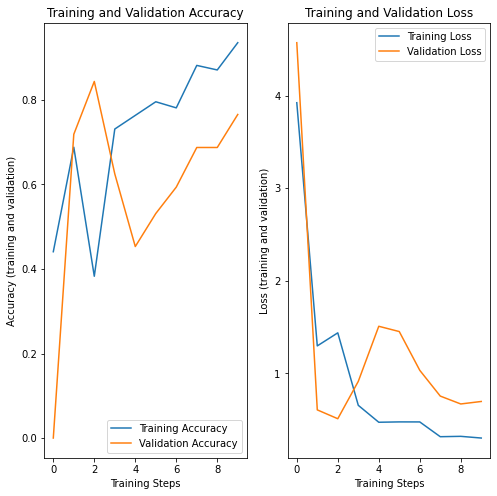

In [33]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()